In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from scipy.stats import f_oneway
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

In [4]:
data = pd.read_excel('82_efgpredict.xlsx')

In [5]:
data.head()

,Season,plyr,Date,Opp,fgm,fga,fg3m,fg3a,ftm,fta,lum,lua,eFG%
0,2013,Player1,2012-10-30,cle,2,8,2,4,2,2,0,1,0.375000
1,2013,Player1,2012-11-03,bos,0,5,0,2,2,2,0,0,0.000000
2,2013,Player1,2012-11-07,bos,6,15,3,8,1,1,2,2,0.500000
3,2013,Player1,2012-11-09,mil,7,14,0,4,8,8,3,3,0.500000
4,2013,Player1,2012-11-10,ind,6,11,3,3,2,3,0,1,0.681818


##### Plot the effective field goal percentage (eFG%) for the designated opponents, namely New Orleans, New York, and Chicago, in comparison to the remaining teams. Does this exhibit a statistically significant distinction?

One-way ANOVA Results:
F-statistic: 0.3634664488921478
p-value: 0.7794679318071123

Tukey HSD Post-Hoc Test Results:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
 Other    chi  -0.0079 0.9984 -0.1328 0.1169  False
 Other    nor     0.02 0.9947 -0.1906 0.2306  False
 Other    nyk   0.0664 0.7521 -0.1067 0.2395  False
   chi    nor   0.0279 0.9904 -0.2119 0.2678  False
   chi    nyk   0.0743 0.7892 -0.1334 0.2821  False
   nor    nyk   0.0464 0.9697 -0.2217 0.3146  False
---------------------------------------------------


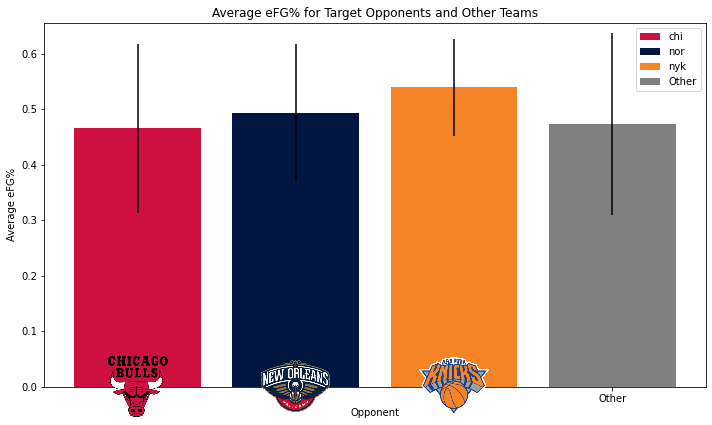

In [26]:
target_measure = 'eFG%'

# Filter data for the target opponents
target_opponents = ['nor', 'nyk', 'chi']
filtered_data = data[data['Opp'].isin(target_opponents)]

# Group data by opponent and calculate the average eFG%
opponent_avg_efg = filtered_data.groupby('Opp')[target_measure].mean()

# Calculate the average eFG% for other opponents
other_opponents = data[~data['Opp'].isin(target_opponents)]
average_efg_others = other_opponents[target_measure].mean()

# Add average eFG% of others to opponent_avg_efg
opponent_avg_efg['Other'] = average_efg_others

# Perform one-way ANOVA
groups = ['nor', 'nyk', 'chi', 'Other']
data_groups = [filtered_data[filtered_data['Opp'] == group][target_measure] for group in groups]

# Compute ANOVA
anova_results = f_oneway(data_groups[0], data_groups[1], data_groups[2], other_opponents[target_measure])


# color
colors = {
    'chi': (206, 17, 65),
    'nyk': (245, 132, 38),
    'nor': (0, 22, 65)
}


image_urls = {
    'chi': 'https://upload.wikimedia.org/wikipedia/en/thumb/6/67/Chicago_Bulls_logo.svg/200px-Chicago_Bulls_logo.svg.png',
    'nyk': 'https://upload.wikimedia.org/wikipedia/en/thumb/2/25/New_York_Knicks_logo.svg/240px-New_York_Knicks_logo.svg.png',
    'nor': 'https://upload.wikimedia.org/wikipedia/en/thumb/0/0d/New_Orleans_Pelicans_logo.svg/230px-New_Orleans_Pelicans_logo.svg.png'
}

# Print ANOVA results
print("One-way ANOVA Results:")
print("F-statistic:", anova_results.statistic)
print("p-value:", anova_results.pvalue)

# Create a list of group labels for the Tukey HSD test
tukey_group_labels = []
for i, group_data in enumerate(data_groups):
    if i == 3:
        # "Other" category
        tukey_group_labels.extend(['Other'] * len(other_opponents))
    else:
        tukey_group_labels.extend([groups[i]] * len(group_data))

# Perform Tukey HSD post-hoc test using statsmodels
data_for_tukey = pd.concat(data_groups + [other_opponents[target_measure]])
tukey_results = pairwise_tukeyhsd(data_for_tukey, groups=tukey_group_labels, alpha=0.05)

# Print Tukey HSD results
print("\nTukey HSD Post-Hoc Test Results:")
print(tukey_results)

# Calculate standard deviations for each opponent
opponent_std_efg = filtered_data.groupby('Opp')[target_measure].std()
opponent_std_efg['Other'] = other_opponents[target_measure].std()

# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars with error bars
for i, (opponent, avg_efg) in enumerate(opponent_avg_efg.items()):
    std_efg = opponent_std_efg[opponent]
    
    if opponent == 'Other':
        color = 'gray'
    else:
        color = colors[opponent]
        color = [x / 255 for x in color]
        
    if opponent != 'Other':
        image_url = image_urls[opponent]
        image = plt.imread(image_url)
        
        # Add image as x-axis tick label
        imagebox = OffsetImage(image, zoom=0.3)
        ab = AnnotationBbox(imagebox, (i, 0), frameon=False, pad=0.1)
        ax.add_artist(ab)
    
    ax.bar(i, avg_efg, yerr=std_efg, color=color, label=opponent if opponent != 'Other' else 'Other')

# Set x-axis labels and title
ax.set_xticks(range(len(opponent_avg_efg)))
ax.set_xticklabels(opponent_avg_efg.index)
ax.set_xlabel('Opponent')
ax.set_ylabel('Average eFG%')
ax.set_title('Average eFG% for Target Opponents and Other Teams')
ax.set_ylim(0, np.max(opponent_avg_efg) + (4*np.std(opponent_avg_efg)))  # Set y-axis limits between 0 and 1 (since eFG% is a percentage)
ax.legend()

plt.tight_layout()
#plt.savefig('Average_eFG%.png')
plt.show()




The lack of statistical power in the test due to the insufficient number of observations might account for the insignificance of the difference. There is also a high mismatch between conditions 

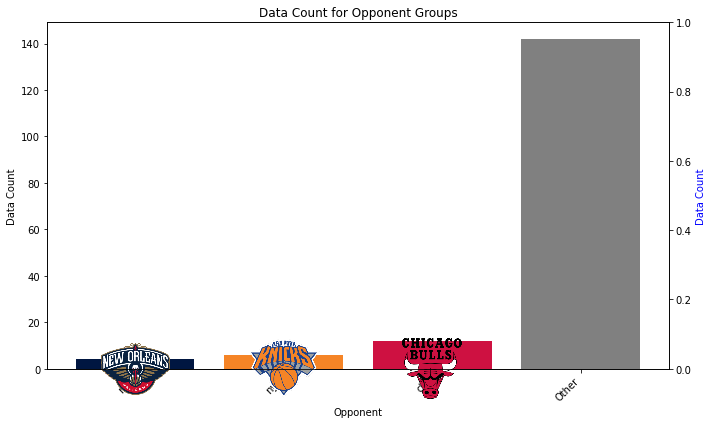

In [40]:
data_counts = [len(group_data) for group_data in data_groups]
data_counts[3] = other_opponents.shape[0]
# Create a figure and axes for the plot
fig, ax = plt.subplots(figsize=(10, 6))
ax2 = ax.twinx()  # Create a twin axes sharing the same x axis

# Plot bars for data counts
for i, count in enumerate(data_counts):
    opponent = groups[i] if i < 3 else 'Other'
    
    if opponent != 'Other':
        color = colors[opponent]
        color = [x / 255 for x in color]
        
        image_url = image_urls[opponent]
        image = plt.imread(image_url)
        
        # Add image as x-axis tick label
        imagebox = OffsetImage(image, zoom=0.3)
        ab = AnnotationBbox(imagebox, (i, 0), frameon=False, pad=0.1)
        ax.add_artist(ab)
    else:
        color = 'gray'
    
    ax.bar(i, count, color=color, label=opponent)

# Set x-axis labels and title for the main axis
tick_locations = np.arange(len(data_counts))
ax.set_xticks(tick_locations)
ax.set_xticklabels(groups , rotation=45, ha="right")
ax.set_xlabel('Opponent')
ax.set_ylabel('Data Count')
ax.set_title('Data Count for Opponent Groups')

# Set y-axis label for the twin axis
ax2.set_ylabel('Data Count', color='blue')

# Display the plot
plt.tight_layout()
plt.show()

In the next cell, the following actions were performed:

Data was read from an Excel file named '82_efgpredict.xlsx' into a DataFrame named 'data'.

A permutation-based linear regression analysis was conducted with 1000 permutations and a test size of 20%. The goal was to assess the stability of model coefficients and the intercept.

For each permutation:

Categorical opponent data was one-hot encoded.
Data was split into training and testing sets.
A Linear Regression model was trained on the training data.
Coefficients and intercept were stored for each permutation.
The average coefficients across permutations and the average intercept were calculated.

This analysis helps understand the robustness of the model's parameters under shuffled data conditions.

In [98]:
from sklearn.model_selection import train_test_split
data = pd.read_excel('82_efgpredict.xlsx')

permutation = 1000
test_size = 0.2
all_intercept = np.zeros((permutation))
all_coef = np.zeros((permutation, np.unique(data['Opp'].to_numpy()).shape[0]))

for perm in range(permutation):
    X = pd.get_dummies(data['Opp']).to_numpy()
    y = data['eFG%'].to_numpy()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    regressor = LinearRegression()
    regressor.fit(X_train, y_train)
    all_coef[perm,:] = regressor.coef_
    all_intercept[perm] = regressor.intercept_

avg_coef = np.mean(all_coef, axis=0)
avg_intercept = np.mean(all_intercept)

The code calculates a prediction score using the defined function, coefficients, and intercept from the linear regression model. The prediction score for the specified team is obtained and returned.

In [118]:
def calc(slope, intercept, team):
    return slope*team+intercept

input4pred = np.zeros(X[0].shape[0])
hot2change = np.where(pd.get_dummies(data['Opp']).keys() =='nor')[0][0]

input4pred[hot2change] = 1

score = calc(regressor.coef_, regressor.intercept_, input4pred)
score[hot2change]

0.5592948717948717